# Assignment

In this assignment we will train a box localization algorithm derived from RetinaNet to perform kidney localization onCT. The algorithm will be implemented using a feature pyramid network backbone. Accuracy will be calculated based on median IoU performance against ground-truth masks.

This assignment is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

### Submission

Once complete, the following items must be submitted:

* final `*.ipynb` notebook (push to https://github.com/[username]/cs190/cnn/assignment.ipynb)
* final trained `*.hdf5` model file
* final compiled `*.csv` file with performance statistics

# Google Colab

The following lines of code will configure your Google Colab environment for this assignment.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [1]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 89 kB 6.4 MB/s 
     |████████████████████████████████| 596 kB 38.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries:

In [2]:
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, models, layers, optimizers
from jarvis.train import datasets
from jarvis.utils.display import imshow
from jarvis.train.box import BoundingBox

# Data

The data used in this tutorial will consist of kidney tumor CT exams derived from the Kidney Tumor Segmentation Challenge (KiTS). More information about he KiTS Challenge can be found here: https://kits21.kits-challenge.org/. The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/ct_kits`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

The following lines of code will:

1. Download the dataset (if not already present) 
2. Prepare the necessary Python generators to iterate through dataset

In [3]:
# --- Download dataset
datasets.download(name='ct/kits')

# --- Prepare generators and model inputs
gen_train, gen_valid, client = datasets.prepare(name='ct/kits', keyword='2d-bin', custom_layers=True)

[ 2022-05-16 03:13:25 ] [====================] 100.000% : Extracting archive (0000818 / 0000818) 

# Training

In this assignment we will train a box localization network for kidney detection.

### Define box parameters

Use the following cell block to define your `BoundingBox` object as discussed in the tutorial. Feel free to optimize hyperparameter choices for grid size, anchor shapes, anchor aspect ratios, and anchor scales: 

In [4]:
bb = BoundingBox(
    image_shape=(96, 96),
    classes=1,
    c=[3, 4],
    anchor_shapes=[16, 32],
    anchor_scales=[0, 1, 2],
    anchor_ratios=[0.5, 1, 2],
    iou_upper=0.5,
    iou_lower=0.2)

### Define inputs

Use the following cell block to define the nested generators needed to convert raw masks into bounding box ground-truth predictions:

In [11]:
def box_generator(G):
    
    for xs, _ in G:
        
        # --- Convert mask into bounding-box paramaterization
        msk = xs.pop('lbl')
        box = bb.convert_msk_to_box(msk=msk)
        
        # --- Update xs dictionary
        xs.update(box)
        
        yield xs

def focal_sigmoid_ce(y_true, y_pred, weights=1.0, scale=1.0, gamma=2.0, alpha=0.25, **kwargs):
    """
    Method to implement focal sigmoid (binary) cross-entropy loss

    """
    # --- Calculate standard cross entropy with alpha weighting
    loss = tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true, logits=y_pred, pos_weight=alpha)

    # --- Calculate modulation to pos and neg labels 
    p = tf.math.sigmoid(y_pred)
    modulation_pos = (1 - p) ** gamma
    modulation_neg = p ** gamma

    mask = tf.cast(y_true, dtype=tf.bool)
    modulation = tf.where(mask, modulation_pos, modulation_neg)

    return tf.math.reduce_mean(modulation * loss * weights * scale)


def huber(y_true, y_pred, weights=1.0, delta=1.0, **kwargs):
    """
    Method to calculate mixed L1/L2 Huber loss
    
    """
    y_true = tf.expand_dims(y_true, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)
    
    loss = tf.keras.losses.huber(
        y_true=y_true,
        y_pred=y_pred,
        delta=delta)
    
    return tf.math.reduce_mean(loss * weights)

def sigmoid_ce_sens(y_true, y_pred, weights=None, threshold=0.5, **kwargs):
    """
    Method to implement sensitivity (recall) on raw sigmoid (binary) cross-entropy logits

    """
    p = tf.math.sigmoid(y_pred)
    tp = (p > threshold) & (y_true > 0)
    
    if weights is not None:
        tp = tp & (weights != 0)
        y_true = (y_true > 0) & (weights != 0)

    num = tf.math.count_nonzero(tp) 
    den = tf.math.count_nonzero(y_true)

    num = tf.cast(num, tf.float32)
    den = tf.cast(den, tf.float32)

    return tf.math.divide_no_nan(num, den)

def sigmoid_ce_ppv(y_true, y_pred, weights=None, threshold=0.5, **kwargs):
    """
    Method to implement PPV (precision) on raw sigmoid (binary) cross-entropy logits

    """
    p = tf.math.sigmoid(y_pred)
    pp = p > threshold
    tp = pp & (y_true == 1)
    
    if weights is not None:
        tp = tp & (weights != 0)
        pp = pp & (weights != 0)

    num = tf.math.count_nonzero(tp) 
    den = tf.math.count_nonzero(pp)

    num = tf.cast(num, tf.float32)
    den = tf.cast(den, tf.float32)
    
    return tf.math.divide_no_nan(num, den)

In [12]:
# --- Prepare generators
gen_train, gen_valid = client.create_generators()
gen_train = box_generator(G=gen_train)
gen_valid = box_generator(G=gen_valid)

### Define backbone model

Use the following cell block to define your feature pyramid network backbone and RetinaNet classification / regression networks:

In [13]:
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same'}

conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)

conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(1, 2, 2))))\

zoom = lambda x : layers.UpSampling3D(
    size=(1, 2, 2))(x)

proj = lambda filters, x : layers.Conv3D(
    filters=filters,
    strides=1,
    kernel_size=(1, 1, 1),
    padding='same',
    kernel_initializer='he_normal')(x)

In [14]:
# --- Define input
x = Input(shape=(None, 96, 96, 1), dtype='float32')

# --- Define model
l1 = conv1(8, x)
l2 = conv1(16, conv2(16, l1))
l3 = conv1(24, conv2(24, l2))
l4 = conv1(32, conv2(32, l3))
l5 = conv1(48, conv2(48, l4))
l6 = proj(64, l5)
l7 = zoom(l6) + proj(64, l4)
c4 = conv1(64, l6)
c3 = conv1(64, l7)

# --- Define logits
logits = {}
K = 1
A = 9

c3_cls = conv1(64, conv1(64, c3))
c3_reg = conv1(64, conv1(64, c3))
logits['cls-c3'] = layers.Conv3D(filters=(A * K), name='cls-c3', **kwargs)(c3_cls)
logits['reg-c3'] = layers.Conv3D(filters=(A * 4), name='reg-c3', **kwargs)(c3_reg)

c4_cls = conv1(64, conv1(64, c4))
c4_reg = conv1(64, conv1(64, c4))
logits['cls-c4'] = layers.Conv3D(filters=(A * K), name='cls-c4', **kwargs)(c4_cls)
logits['reg-c4'] = layers.Conv3D(filters=(A * 4), name='reg-c4', **kwargs)(c4_reg)
# --- Create model
backbone = Model(inputs=x, outputs=logits)

### Define training model

Recall the following requirements as described in the tutorial:

* use of a focal sigmoid (binary) cross-entropy loss function for regression
* use of a Huber loss function for classification
* use of masked loss functions to ensure only relevant examples are used for training
* use of appropriate metrics to track algorithm training

In [17]:
xs = next(gen_train)
msk = bb.convert_box_to_msk(box=xs, apply_deltas=False)

In [18]:
# --- Define inputs
inputs = {k: Input(shape=[None] + list(v.shape[2:]), dtype='float32', name=k) for k, v in xs.items()}

# --- Define model
logits = backbone(inputs['dat'])

In [19]:
# --- Define losses

losses = {}

for key in ['cls-c3', 'cls-c4']:
    
    losses[key] = focal_sigmoid_ce(
        y_true=inputs[key],
        y_pred=logits[key],
        weights=inputs[key + '-msk'])


In [20]:
# --- Define metric
metric = {}

for key in ['cls-c3', 'cls-c4']:
    
    metric[key + '-sen'] = sigmoid_ce_sens(
        y_true=inputs[key],
        y_pred=logits[key],
        weights=inputs[key + '-msk'])
    
    metric[key + '-ppv'] = sigmoid_ce_ppv(
        y_true=inputs[key],
        y_pred=logits[key],
        weights=inputs[key + '-msk'])

In [21]:
for key in ['reg-c3', 'reg-c4']:
    
    losses[key] = huber(
        y_true=inputs[key],
        y_pred=logits[key],
        weights=inputs[key + '-msk'])

Now, we are ready to create the `training` model and add the corresponding loss and accuracy tensors. 

In [22]:
# --- Create model
training = Model(inputs=inputs, outputs=logits)

# --- Add losses
for key, l in losses.items():
    training.add_loss(l)

# --- Add metric
for key, m in metric.items():
    training.add_metric(m, name=key)

### Compile the model

Use the following cell block to compile your model with an appropriate optimizer. 

In [23]:
optimizer = optimizers.Adam(learning_rate=2e-4)
training.compile(optimizer=optimizer)

### In-memory data

To speed up training, consider loading all your model data into RAM memory:

In [24]:
# --- Load data into memory for faster training
client.load_data_in_memory()

[ 2022-05-16 03:23:03 ] [====================] 100.000% : Iterating | 000402    

### Train the model

Use the following cell block to train your model.

In [25]:
training.fit(
    x=gen_train, 
    steps_per_epoch=100, 
    epochs=20,
    validation_data=gen_valid,
    validation_steps=100,
    validation_freq=5)

Epoch 1/20
100/100 [==============================] - 24s 62ms/step - loss: 0.1387 - cls-c3-sen: 0.1721 - cls-c3-ppv: 0.0119 - cls-c4-sen: 0.1527 - cls-c4-ppv: 0.2933
Epoch 2/20
100/100 [==============================] - 8s 79ms/step - loss: 0.0116 - cls-c3-sen: 4.1667e-04 - cls-c3-ppv: 8.3333e-04 - cls-c4-sen: 0.1414 - cls-c4-ppv: 0.7516
Epoch 3/20
100/100 [==============================] - 7s 67ms/step - loss: 0.0063 - cls-c3-sen: 0.0000e+00 - cls-c3-ppv: 0.0000e+00 - cls-c4-sen: 0.2313 - cls-c4-ppv: 0.8735
Epoch 4/20
100/100 [==============================] - 6s 63ms/step - loss: 0.0046 - cls-c3-sen: 0.0000e+00 - cls-c3-ppv: 0.0000e+00 - cls-c4-sen: 0.3357 - cls-c4-ppv: 0.9066
Epoch 5/20
100/100 [==============================] - 12s 124ms/step - loss: 0.0037 - cls-c3-sen: 0.0000e+00 - cls-c3-ppv: 0.0000e+00 - cls-c4-sen: 0.4745 - cls-c4-ppv: 0.9344 - val_loss: 0.0038 - val_cls-c3-sen: 5.2632e-04 - val_cls-c3-ppv: 0.0100 - val_cls-c4-sen: 0.5565 - val_cls-c4-ppv: 0.9069
Epoch 6/20
1

# Evaluation

Based on the tutorial discussion, use the following cells to calculate model performance. The following metrics should be calculated:

* median IoU
* 25th percentile IoU
* 75th percentile IoU

### Performance

The following minimum performance metrics must be met for full credit:

* median IoU: >0.50
* 25th percentile IoU: >0.40
* 75th percentile IoU: >0.60

In [26]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True)
test_train = box_generator(test_train)
test_valid = box_generator(test_valid)

In [27]:
x = next(test_train)
box = training.predict(x)

[ 2022-05-16 03:25:51 ] [>...................] 0.312% : Iterating | 000001      

In [28]:
anchors, classes = bb.convert_box_to_anc(box)

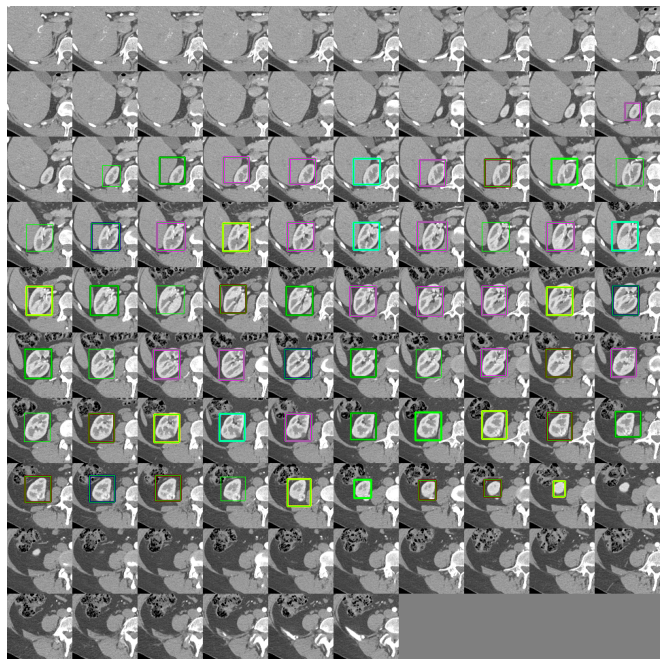

In [29]:
msk = bb.convert_box_to_msk(box, iou_nms=0.2)
imshow(x['dat'][0], msk[0], figsize=(12, 12))

In [30]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True)
test_train = box_generator(test_train)
test_valid = box_generator(test_valid)

ious = {
    'med': [],
    'p25': [],
    'p75': []}

for x in test_valid:
    
    # --- Predict
    box = training.predict(x)
        
    # --- Convert predictions to anchors
    anchors_pred, _ = bb.convert_box_to_anc(box, iou_nms=0.2)
    
    # --- Convert ground-truth to anchors
    anchors_true, _ = bb.convert_box_to_anc(x)
    
    # --- Calculate IoUs
    curr = []
    for pred, true in zip(anchors_pred, anchors_true):
        for p in pred:
            iou = bb.calculate_ious(box=p, anchors=true)
            if iou.size > 0:
                curr.append(np.max(iou))
            else: 
                curr.append(0)
    
    if len(curr) == 0:
        curr = [0]
        
    ious['med'].append(np.median(curr))
    ious['p25'].append(np.percentile(curr, 25))
    ious['p75'].append(np.percentile(curr, 75))
    
ious = {k: np.array(v) for k, v in ious.items()}

[ 2022-05-16 03:27:15 ] [====================] 100.000% : Iterating | 000081    

### Results

When ready, create a `*.csv` file with your compiled **validation** cohort IoU statistics. There is no need to submit training performance accuracy.

In [31]:
# --- Define columns
df = pd.DataFrame(index=np.arange(ious['med'].size))
df['iou_median'] = ious['med']
df['iou_p-25th'] = ious['p25']
df['iou_p-75th'] = ious['p75']

# --- Print accuracy
print(df['iou_median'].median())
print(df['iou_p-25th'].median())
print(df['iou_p-75th'].median())

0.7631290555000305
0.6911551058292389
0.8190743625164032


In [32]:
df.to_csv('./wjhan_results.csv')

# Submission

Use the following line to save your model for submission (in Google Colab this should save your model file into your personal Google Drive):

In [33]:
# --- Serialize a model
backbone.save('./wjhan_model.hdf5')

### Canvas

Once you have completed this assignment, download the necessary files from Google Colab and your Google Drive. You will then need to submit the following items:

* final (completed) notebook: `[UCInetID]_assignment.ipynb`
* final (results) spreadsheet: `[UCInetID]_results.csv`
* final (trained) model: `[UCInetID]_model.hdf5`

**Important**: please submit all your files prefixed with your UCInetID as listed above. Your UCInetID is the part of your UCI email address that comes before `@uci.edu`. For example, Peter Anteater has an email address of panteater@uci.edu, so his notebooke file would be submitted under the name `panteater_notebook.ipynb`, his spreadshhet would be submitted under the name `panteater_results.csv` and and his model file would be submitted under the name `panteater_model.hdf5`.